# 02 | Experimentos "Máximo"

In [2]:
import subprocess
import multiprocessing
import pandas as pd
import numpy as np
import os
from pathlib import Path
from IPython.display import display, clear_output
from random import randint

In [3]:
# CONSTANTES
ASCII_A = 97
ASCII_Z = 122

# PARA EXPERIMENTOS

# Longitud de palabras
WORD_SIZE = 10

# Cantidad de palabras
START = 50000
END = 500000
STEP = 50000

## 2.1 Generación de instancias

In [5]:
def generar_archivo_uniforme(file_name, word_len, words_count):
    os.makedirs(F"../data/", exist_ok=True)
    file_path = "../data/" + file_name
    file = open(file_path, "w")

    for i in range(words_count):
        word = ""
        for j in range(word_len): word += chr(randint(ASCII_A, ASCII_Z))
        file.write(word + "\n")

    return file_path

In [6]:
def generar_archivo_normal(file_name, word_len, words_count):
    # a b c d e f g h i j k l m <- 13 -> n o p q r s t u v w x y z
    MU, SIGMA = 109.5, 8
    os.makedirs(F"../data/", exist_ok=True)
    file_path = "../data/" + file_name
    file = open(file_path, "w")

    for i in range(words_count):
        word = ""
        # Muestreamos hasta que obtengamos una palabra de 'word_len' letras, de la 'a' a la 'z' 
        while len(word) < word_len:
            sample = int(np.random.normal(MU, SIGMA))
            if ASCII_A <= sample <= ASCII_Z:
                word += chr(sample)

        file.write(word + "\n")

    file.close()
    return file_path

In [7]:
# Genera las instancias uniforme-START, uniforme-{START+STEP}, ..., uniforme-END y normal-START, normal-{START+STEP}, ..., normal-END
for k in range(START, END + 1, STEP):
    generar_archivo_uniforme(F"uniforme-{k}", WORD_SIZE, k)
    generar_archivo_normal(F"normal-{k}", WORD_SIZE, k)

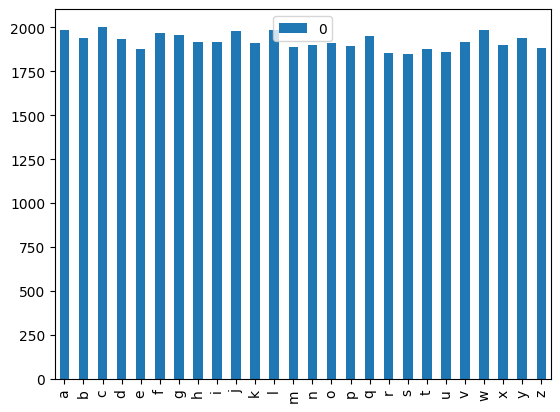

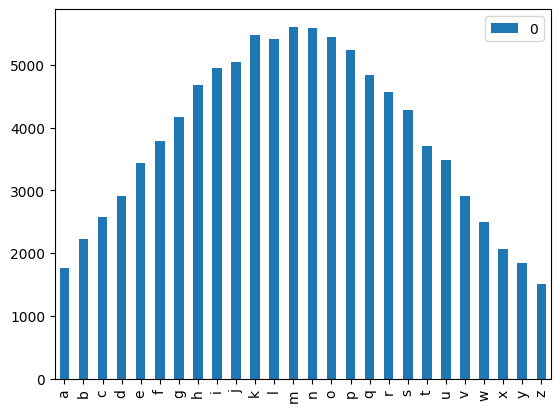

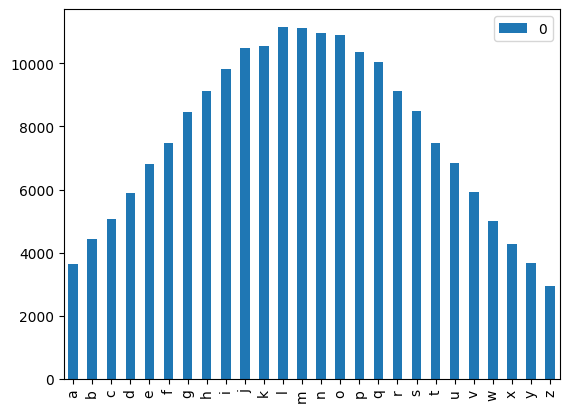

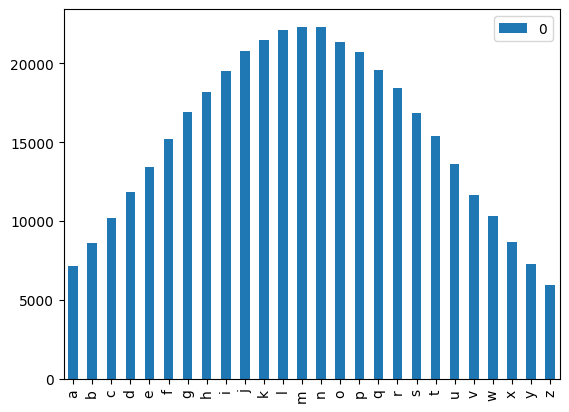

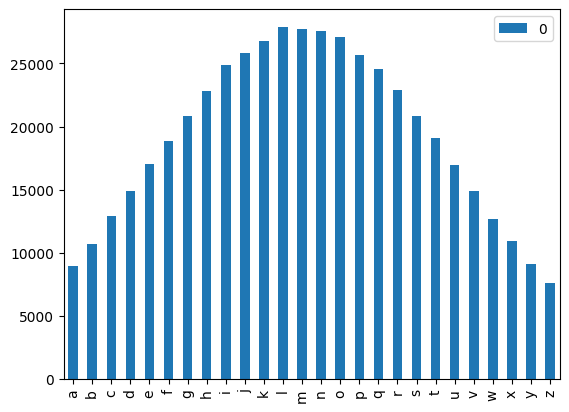

In [8]:
# Distribución de las muestras

from collections import Counter

# Uniforme
dataset = pd.read_table("../data/uniforme-50000", header=None)
letters = [w[0] for w in dataset[0].values.tolist()]
letters.sort()
letter_count = Counter(letters)
df = pd.DataFrame.from_dict(letter_count, orient='index')
df.plot(kind='bar')

# Normal 
rango = [100000, 200000, 400000, 500000]
for r in rango: 
    dataset = pd.read_table(f"../data/normal-{r}", header=None)
    letters = [w[0] for w in dataset[0].values.tolist()]
    letters.sort()
    letter_count = Counter(letters)
    df = pd.DataFrame.from_dict(letter_count, orient='index')
    df.plot(kind='bar')


## 2.2 Funciones auxiliares

In [15]:
def correr_maximo(archivo_entrada, con_threads=False, cant_threads=0):
    algorithm = "paralelo" if con_threads else "maximo"    
    # Crear proceso para ejecutar el codigo.
    print("Máximo", archivo_entrada)
    if (con_threads):
        process = subprocess.Popen([F"../build/{algorithm}", str(cant_threads), os.path.abspath(archivo_entrada)], stderr=subprocess.PIPE, stdout=subprocess.PIPE, universal_newlines = True)
    else:
        process = subprocess.Popen([F"../build/{algorithm}", os.path.abspath(archivo_entrada)], stderr=subprocess.PIPE, stdout=subprocess.PIPE, universal_newlines = True)

    # Correr experimento.
    exit_code = process.wait()

    # Verificar que el proceso no fallo.
    if exit_code != 0:
        print(exit_code)
        print(process.stderr.read())
        process.stderr.close()
        raise(F"Hubo un error en la experimentacion: {algorithm} con la instancia {archivo_entrada}.")
    # Leer salida de STDERR con los tiempos de ejecucion de cada metodo.
    tiempo_de_ejecucion = float(process.stdout.read())
    
    process.stdout.close()
    process.stderr.close()
       
    return tiempo_de_ejecucion

## 2.3 Experimentos

### Experimento: Tiempos de ejecución para Máximo Paralelo en función de la cantidad de threads

In [16]:
ITERACIONES = 5
THREADS = multiprocessing.cpu_count()
COLUMNS = ["dataset", "threads", "tiempo"]
entries = []
result_dir = "maximo-tiempos"
datasets = ["uniforme-100000", "normal-100000", "uniforme-200000", "normal-200000", "uniforme-400000", "normal-400000", "uniforme-500000", "normal-500000"]

for dataset in datasets:
    file = "../data/" + dataset
    for t in range(1, THREADS + 1):
        for i in range(ITERACIONES):
            clear_output(wait=True)
            display(F"Ejecutando archivo {file} con cantidad de Threads {t} (Iteración {i}/{ITERACIONES})")
            time = correr_maximo(file, True, t)
            entries.append([dataset, t, time])


df_resultado = pd.DataFrame(entries, columns=COLUMNS)
os.makedirs(F"results/{result_dir}/", exist_ok=True)

clear_output(wait=True)
display(F"Guardando los resultados en el archivo results/{result_dir}/indice.csv")
df_resultado.to_csv(F"results/{result_dir}/indice.csv", index=False, header=True)

'Guardando los resultados en el archivo results/maximo-tiempos/indice.csv'

### Experimento: Tiempo de ejecución para una cantidad de threads "óptima" vs. utilizar un thread, en función de la cantidad de palabras

In [9]:
ITERACIONES = 5
CANT_THREADS = multiprocessing.cpu_count()
COLUMNS = ["dataset", "funcion", "palabras", "tiempo"]
entries = []
result_dir = "maximo-single-vs-paralelo"
datasets = ["uniforme", "normal"]

for dataset in datasets:
    for p in range(START, END + 1, STEP):
        file = F"../data/{dataset}-{p}"
        for i in range(ITERACIONES):
            # Máximo paralelo
            clear_output(wait=True)
            display(F"Ejecutando MÁXIMO PARALELO archivo {file} con cantidad de PALABRAS {p} (Iteración {i}/{ITERACIONES})")
            time = correr_maximo(file, True, CANT_THREADS)
            entries.append([dataset, "maximoParalelo", p, time])
        for i in range(ITERACIONES):
            # Máximo sin threading
            clear_output(wait=True)
            display(F"Ejecutando MÁXIMO NORMAL archivo {file} con cantidad de PALABRAS {p} (Iteración {i}/{ITERACIONES})")
            time = correr_maximo(file)
            entries.append([dataset, "maximo", p, time])


df_resultado = pd.DataFrame(entries, columns=COLUMNS)
os.makedirs(F"results/{result_dir}/", exist_ok=True)

clear_output(wait=True)
display(F"Guardando los resultados en el archivo results/{result_dir}/indice.csv")
df_resultado.to_csv(F"results/{result_dir}/indice.csv", index=False, header=True)

'Guardando los resultados en el archivo results/maximo-single-vs-paralelo/indice.csv'